In [1]:
from aicspylibczi import CziFile
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.animation as animation
import IPython
from IPython.display import HTML

from multiprocessing import Pool
import cv2
import os
import ffmpeg
import time
import pandas as pd
from cellpose import io, models

In [2]:
from skimage.measure import label # version at least 0.22
from skimage.measure import regionprops_table # version at least 0.22
from skimage.filters import threshold_otsu # version at least 0.22
from utils import *

In [3]:
video = get_file('mip', 3)

Loading dicty_factin_pip3-03_MIP.czi with dims [{'X': (0, 474), 'Y': (0, 2048), 'C': (0, 2), 'T': (0, 90)}]


In [4]:
frames, shp = video.read_image(C=0)


In [5]:
%%time
frames = scale_img(frames.squeeze())
frames.shape

CPU times: user 2.26 s, sys: 341 ms, total: 2.6 s
Wall time: 2.6 s


(90, 2048, 474)

In [6]:
frames.dtype

dtype('float64')

In [22]:
def frame_otsu_thresholding(frame):
    return (frame >= threshold_otsu(frame))

def frame_connected_components(thresholded_frame):
    return label(thresholded_frame, background=0, connectivity=2)

def binarize_video_fast(frames):

    # computes a unique otsu threshhold for all videos
    with Pool(processes=os.cpu_count()) as pool:
        # Map apply_otsu_threshold to each frame
        video_threshed = pool.map(frame_otsu_thresholding, frames)
        video_labeled = pool.map(frame_connected_components, video_threshed)
    
    return video_labeled

In [23]:
%%time
masks = binarize_video_fast(frames)

CPU times: user 804 ms, sys: 1.32 s, total: 2.13 s
Wall time: 2.24 s


In [24]:
%%time
masks = binarize_video(frames)

CPU times: user 1.95 s, sys: 288 ms, total: 2.24 s
Wall time: 2.24 s


In [25]:
def bounding_boxes(mask, min_area=300):    
    # deducing centroids, max side length, 
    all_bboxes_coords = list()
    max_num_cells=0
    num_cells_frames = list()
    # region props can calculate a LOT of useful properties
    # might want to look into better cell filtering
    props = regionprops_table(label_image=mask,
                              properties=['bbox','area']
    )
    # each row corresponds to cell id, columns corresponds to properties
    # box returned as min_row, min_col, max_row, max_col
    df = pd.DataFrame(props)
    df = df[df['area'] >= min_area]
    cell_areas = df['area'].values
    df= df.drop(columns = ['area'])
    bboxes, num_cells = list(df.itertuples(index=False, name=None)), df.shape[0]
    return bboxes, num_cells, cell_areas

In [26]:
def box_tracking_video(frames, masks=-1, thickness=2):
    if(type(masks) == int):
        # if not provided, calculated
        masks = binarize_video(frames)
        print("Computed binary masks")
    video = []
    num_cells_per_frame = []
    cell_areas = []
    for frame_idx in range(len(frames)):
        boxes, num_cells, areas = bounding_boxes(masks[frame_idx])
        num_cells_per_frame.append(num_cells)
        cell_areas.append(areas)

        img_with_boxes = draw_boxes(frames[frame_idx], boxes, thickness, val=1)
        video.append(img_with_boxes)
        
    return(video, num_cells_per_frame, cell_areas)

In [57]:
s = 8
i=5
list(range(max(0, s-i), s))

[3, 4, 5, 6, 7]

In [87]:
def track_cells(cell_id, frames, masks=-1, padding=0, history_length=1, verbose=False):
    N = frames.shape[0]
    if(type(masks) == int):
        # if not provided, calculated
        masks = binarize_video(frames)
        print("Computed binary masks")

    data = {"patches" : [], 'boxes' : [], "masks" : []}
    areas_frames = []
    num_cells_frames = []
    
    def get_corresponding_cell_box(curr_boxes, curr_num, curr_areas, frame_idx, num_past_to_consider, verbose=False):
        ## TO DO : Ensure that index of boxes stays consistent even as boxes appear and dissapear
        if(frame_idx == 0):
            return(cell_id)

        assert len(data['boxes']) >= frame_idx, f"Missing frame history at {frame_idx}"
        
        scores = np.zeros(len(boxes))
        for i in range(max(0, len(data['boxes']) - num_past_to_consider), len(data['boxes'])):
            prev_box, prev_num, prev_area = data['boxes'][i], num_cells_frames[i], areas_frames[i]
            for j in range(len(scores)):
                delta_area = abs(prev_area - curr_areas[j])
                delta_x = abs(prev_box[0] - curr_boxes[j][0])
                delta_y = abs(prev_box[1] - curr_boxes[j][1])
                if(verbose):
                    print(f"Score {j} comprised of {delta_area}, {delta_x}, {delta_y}")
                scores[j] += 50*(delta_x + delta_y) + delta_area / 30
        index = np.argmin(scores)
        if(index != cell_id and verbose):
            print(f"Choosing {index} instead of cell id {cell_id} at frame {frame_idx}\nAreas: {curr_areas}\n boxes: {curr_boxes}")
            print(f"Previous box and area: {prev_box}\n {prev_area}")
            print("\n\n\n")
        return(index)
    
    h_max, w_max = 0, 0
    skip_frames = []
    for frame_idx in range(N):
        boxes, num_cells, areas = bounding_boxes(masks[frame_idx]) # all on frame
        index_of_cell = get_corresponding_cell_box(boxes, num_cells, areas, frame_idx, history_length, verbose) # right now assume same index throughout entire video
        
        bbox = boxes[index_of_cell] # cell id is meant to track a SPECIFIC cell, ensure maintain integrity of cell over time
        min_row, min_col, max_row, max_col = bbox
        #TODO might expand boxes to homogenize sizes; 
        min_row -= padding
        min_col -= padding # adjust boxes based on padding
        max_row += padding
        max_col += padding

        patch = frames[frame_idx, min_row:max_row, min_col:max_col]
        mask_patch = masks[frame_idx, min_row:max_row, min_col:max_col]

        data['boxes'].append((min_row, min_col, max_row, max_col))
        data['patches'].append(patch)
        data['masks'].append(mask_patch)

        num_cells_frames.append(num_cells)
        areas_frames.append(areas[index_of_cell])

    return(data)

In [28]:
def draw(img, box, thickness, val):
    min_row, min_col, max_row, max_col = box
    img = cv2.rectangle(img, (min_col, min_row), (max_col, max_row), val, thickness)
    return(img)

def draw_boxes(frame, boxes, thickness=2, val=1, cell_id=-1):
    img = frame.copy()
    
    if(cell_id==-1):
        for bbox in boxes:
            img = draw(img, bbox, thickness, val)
    else:
        img = draw(img, boxes[cell], thickness, val) 
        
    return(img)

In [29]:
%%time
data = track_cells(4, frames, masks, padding=0, verbose=False)

CPU times: user 650 ms, sys: 0 ns, total: 650 ms
Wall time: 650 ms


In [39]:
def visualize_cell_tracker(frames, data, thickness=2, val=1):
    video_frames = []
    for frame_idx in range(len(frames)):
        box = data['boxes'][frame_idx]
        img = draw(frames[frame_idx].copy(), box, thickness, val)
        video_frames.append(img)
    return(video_frames)

video_cell_4 = np.array(visualize_cell_tracker(frames, data))

In [33]:
video, cell_nums, areas = box_tracking_video(frames, masks)

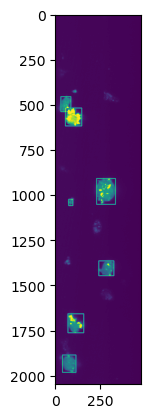

In [34]:
imshow(video[2])

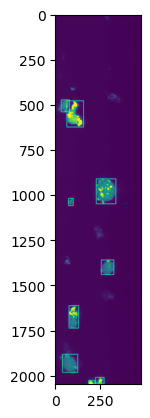

In [35]:
imshow(video[4])

In [30]:
def animate_frames(frames):
    fig = plt.figure()
    im = plt.imshow(frames[0])
    
    plt.close() # this is required to not display the generated image
    
    def init():
        im.set_data(frames[0])
    
    def animate(i):
        im.set_data(frames[i])
        return im
    
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(frames),
                                   interval=200)
    
    HTML(anim.to_html5_video())
    plt.show()
    return(anim)

In [31]:
import time
time.time()

1713734387.3142734

In [46]:
%%time
start = time.time()
data = track_cells(6, frames, masks, padding=0, verbose=False)
print(f"Track time is {1000*(time.time() - start)}ms")
video_cell = np.array(visualize_cell_tracker(frames, data))
print(f"Video creation time is {1000*(time.time() - start)}ms")
anim = animate_frames(video_cell)
print(f"Animation time is {1000*(time.time() - start)}ms")
HTML(anim.to_html5_video())

Track time is 630.3272247314453ms
Video creation time is 1164.2751693725586ms
Animation time is 11282.115697860718ms
CPU times: user 10.6 s, sys: 489 ms, total: 11.1 s
Wall time: 11.3 s


In [47]:
len(data['boxes'])

90

In [32]:
#anim = animate_frames(data['patches'])
#HTML(anim.to_html5_video())

In [33]:
bboxes, num_cells, areas = bounding_boxes(masks[0])

In [36]:
bboxes, num_cells, areas

([(422, 31, 533, 87),
  (535, 55, 630, 166),
  (900, 228, 1042, 332),
  (1025, 76, 1059, 97),
  (1363, 240, 1447, 330),
  (1690, 63, 1784, 148),
  (1883, 44, 1983, 115)],
 7,
 array([ 3662.,  6367., 10794.,   345.,  3789.,  4684.,  4332.]))

In [89]:
def extract_traces(frames, masks, hist=2):
    bboxes, num_cells, areas = bounding_boxes(masks[0])
    vid_data = []
    videos_for_checking = []
    for i in range(num_cells):
        print("Extracting cell ", i)
        data = track_cells(i, frames, masks, padding=0, history_length=hist, verbose=False)
        vid_data.append(data)
        videos_for_checking.append(np.array(visualize_cell_tracker(frames, data)))

    return(vid_data, videos_for_checking)

In [92]:
data, videos = extract_traces(frames[:15], masks[:15], hist=5)

Extracting cell  0
Extracting cell  1
Extracting cell  2
Extracting cell  3
Extracting cell  4
Extracting cell  5
Extracting cell  6


In [93]:
anim = animate_frames(videos[1])
HTML(anim.to_html5_video())

In [35]:
def process_video(czi, sequence_length=10):

    
    
    num_frames = len(frames)
    assert num_frames == len(masks), "frames and masks do not correspond length"

    
    

NameError: name 'bbox' is not defined